In [1]:
pip install pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
df_sales = pd.read_csv("/workspaces/test_repo2/umsatzdaten_gekuerzt (1).csv")

df_sales.head(5)

,id,Datum,Warengruppe,Umsatz
0,1307011,2013-07-01,1,148.828353
1,1307021,2013-07-02,1,159.793757
2,1307031,2013-07-03,1,111.885594
3,1307041,2013-07-04,1,168.864941
4,1307051,2013-07-05,1,171.280754


In [4]:
# map Warengruppe to product group names and add as a new column at the end
mapping = {
    1: "BROT",
    2: "BROTCHEN",
    3: "CROISSANT",
    4: "KONDITOREI",
    5: "KUCHEN",
    6: "SAISONBROT",
}

df_sales["product_groups"] = df_sales["Warengruppe"].map(mapping)

# ensure column is at the end (mapping already appends it, but enforce order)
cols = [c for c in df_sales.columns if c != "product_groups"] + ["product_groups"]
df_sales = df_sales[cols]

# save to a new CSV file in the same workspace
out_path = "/workspaces/test_repo2/umsatzdaten_gekuerzt_with_product_groups.csv"
df_sales.to_csv(out_path, index=False)

# show result
df_sales.head()

,id,Datum,Warengruppe,Umsatz,product_groups
0,1307011,2013-07-01,1,148.828353,BROT
1,1307021,2013-07-02,1,159.793757,BROT
2,1307031,2013-07-03,1,111.885594,BROT
3,1307041,2013-07-04,1,168.864941,BROT
4,1307051,2013-07-05,1,171.280754,BROT


In [5]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 9333
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9334 non-null   int64  
 1   Datum           9334 non-null   object 
 2   Warengruppe     9334 non-null   int64  
 3   Umsatz          9334 non-null   float64
 4   product_groups  9334 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 364.7+ KB


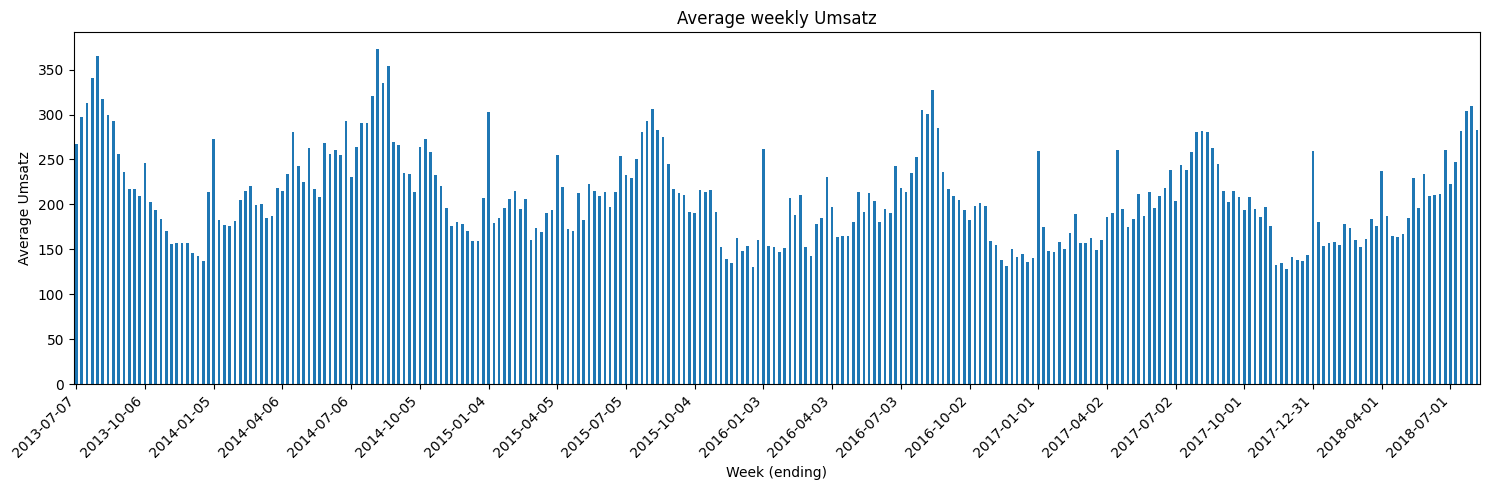

In [6]:
# compute and plot average weekly "Umsatz"
df_sales["Datum"] = pd.to_datetime(df_sales["Datum"])

# weekly average (week ending on Sunday)
weekly_avg = df_sales.set_index("Datum").resample("W")["Umsatz"].mean()

fig, ax = plt.subplots(figsize=(15, 5))
weekly_avg.plot(kind="bar", ax=ax, color="tab:blue")
ax.set_title("Average weekly Umsatz")
ax.set_xlabel("Week (ending)")
ax.set_ylabel("Average Umsatz")

# show fewer x-tick labels for readability
step = max(1, len(weekly_avg) // 20)
ax.set_xticks(range(0, len(weekly_avg), step))
ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in weekly_avg.index[::step]], rotation=45, ha="right")

plt.tight_layout()
plt.show()

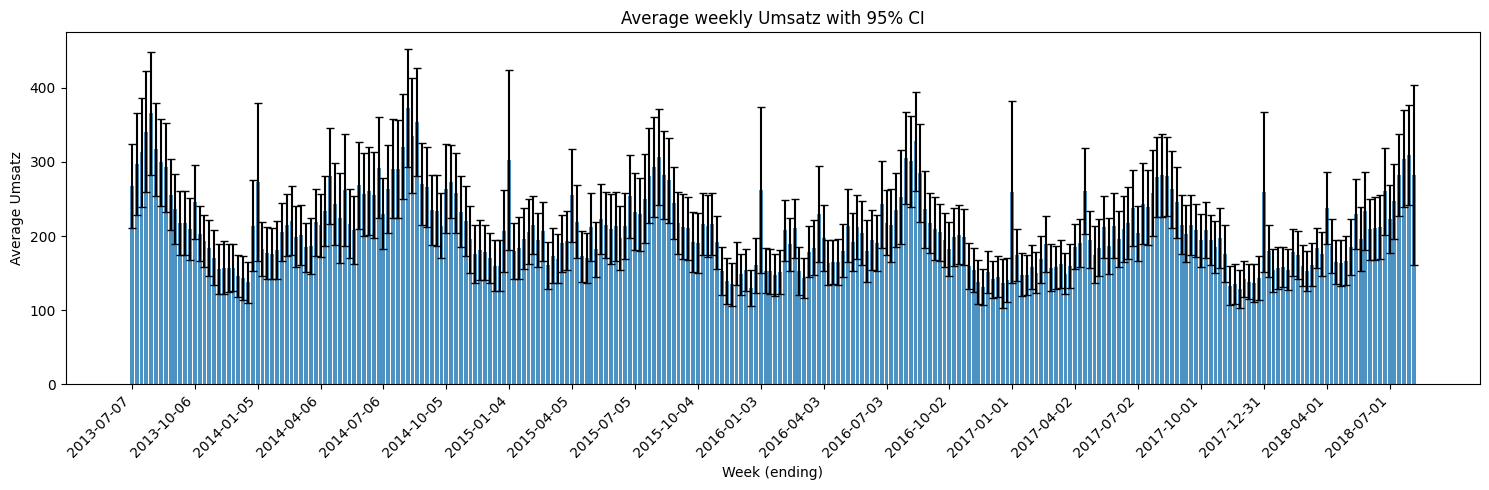

In [7]:
# compute weekly mean, std and count (needed for CIs)
weekly_stats = df_sales.set_index("Datum").resample("W")["Umsatz"].agg(["mean", "std", "count"])

# avoid NaNs for std/sem when count <= 1
weekly_stats["std"] = weekly_stats["std"].fillna(0)
sem = weekly_stats["std"] / np.sqrt(weekly_stats["count"].replace(0, np.nan))
sem = sem.fillna(0)

# 95% CI (approximate using normal z=1.96)
z = 1.96
ci_lower = weekly_stats["mean"] - z * sem
ci_upper = weekly_stats["mean"] + z * sem

# plot mean with error bars representing the 95% CI
fig_ci, ax_ci = plt.subplots(figsize=(15, 5))
x = np.arange(len(weekly_stats))
ax_ci.bar(x, weekly_stats["mean"], yerr=z * sem, capsize=3, color="tab:blue", alpha=0.8)
ax_ci.set_title("Average weekly Umsatz with 95% CI")
ax_ci.set_xlabel("Week (ending)")
ax_ci.set_ylabel("Average Umsatz")

# reuse existing step logic for x-ticks
step = max(1, len(weekly_stats) // 20)
ax_ci.set_xticks(range(0, len(weekly_stats), step))
ax_ci.set_xticklabels([d.strftime("%Y-%m-%d") for d in weekly_stats.index[::step]], rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [8]:
# plot horizontal bars that span the 95% CI for each week (reuse ax_ci)
ax_ci.cla()

y = np.arange(len(ci_lower))
left = ci_lower.values
width = (ci_upper - ci_lower).values

ax_ci.barh(y, width, left=left, color="tab:blue", alpha=0.6, edgecolor="k")
ax_ci.scatter(weekly_stats["mean"].values, y, color="white", edgecolor="k", s=20, zorder=3)  # mean markers

ax_ci.set_title("Weekly Umsatz 95% CI (horizontal)")
ax_ci.set_xlabel("Umsatz")
ax_ci.set_ylabel("Week (ending)")

# show fewer y-tick labels for readability using existing step
ax_ci.set_yticks(range(0, len(y), step))
ax_ci.set_yticklabels([d.strftime("%Y-%m-%d") for d in weekly_stats.index[::step]])
ax_ci.invert_yaxis()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [10]:
# create an ordered weekday column (Monday..Sunday) and demonstrate sorted results
ordered_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_sales["weekday"] = pd.Categorical(df_sales["Datum"].dt.day_name(), categories=ordered_weekdays, ordered=True)

# counts and mean Umsatz in Monday..Sunday order
weekday_counts = df_sales["weekday"].value_counts().sort_index()
weekday_avg = df_sales.groupby("weekday")["Umsatz"].mean()

print("Counts by weekday (Mon-Sun):")
print(weekday_counts)
print("\nAverage Umsatz by weekday (Mon-Sun):")
print(weekday_avg)

# optionally get dataframe sorted by weekday (then by date)
df_sales_sorted = df_sales.sort_values(["weekday", "Datum"])
df_sales_sorted.head()

Counts by weekday (Mon-Sun):
weekday
Monday       1324
Tuesday      1345
Wednesday    1342
Thursday     1334
Friday       1311
Saturday     1336
Sunday       1342
Name: count, dtype: int64

Average Umsatz by weekday (Mon-Sun):
weekday
Monday       193.688449
Tuesday      187.944440
Wednesday    187.477523
Thursday     193.232274
Friday       196.796023
Saturday     241.319882
Sunday       246.495651
Name: Umsatz, dtype: float64


/tmp/ipykernel_20844/2515901321.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_avg = df_sales.groupby("weekday")["Umsatz"].mean()


,id,Datum,Warengruppe,Umsatz,product_groups,weekday
0,1307011,2013-07-01,1,148.828353,BROT,Monday
1819,1307012,2013-07-01,2,535.856285,BROTCHEN,Monday
3638,1307013,2013-07-01,3,201.198426,CROISSANT,Monday
5457,1307014,2013-07-01,4,65.890169,KONDITOREI,Monday
7223,1307015,2013-07-01,5,317.475875,KUCHEN,Monday


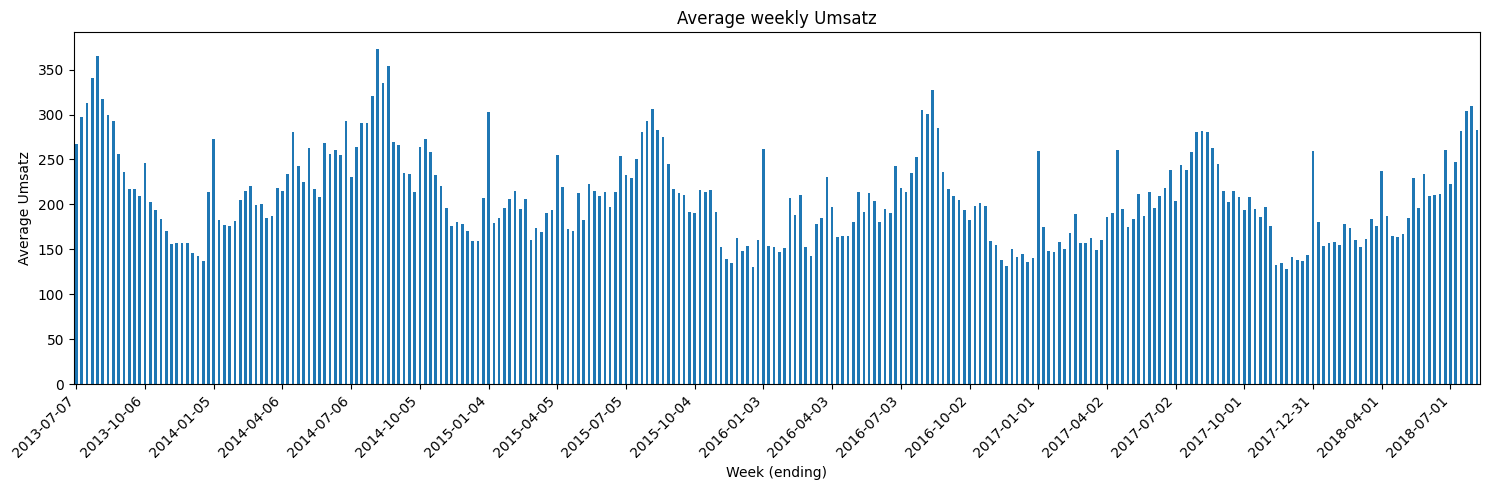

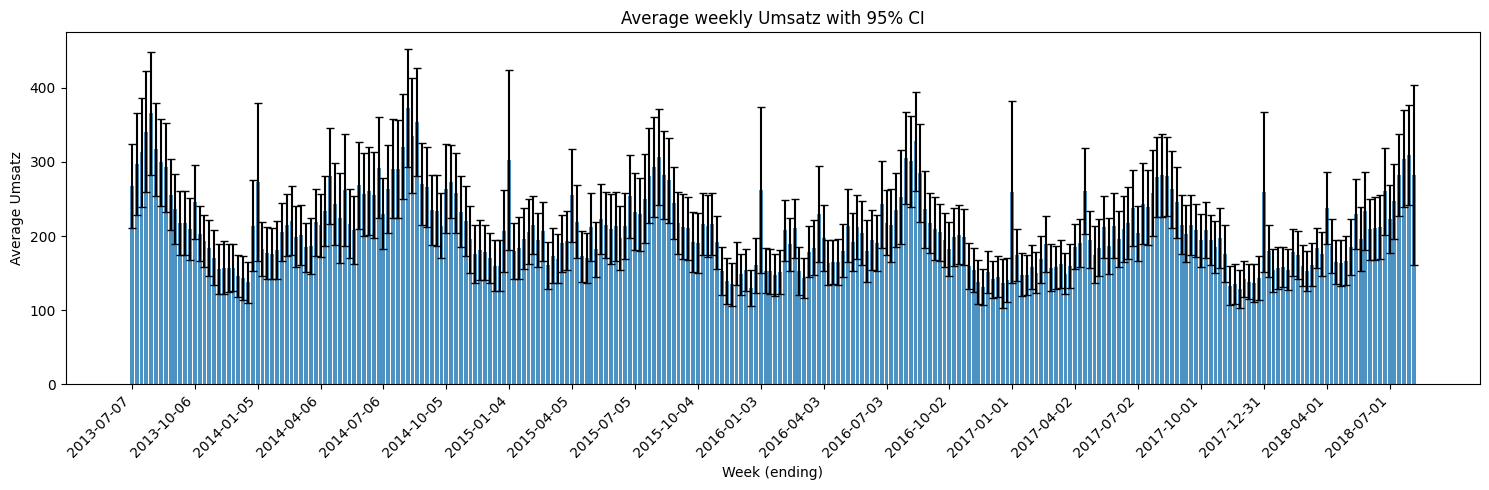

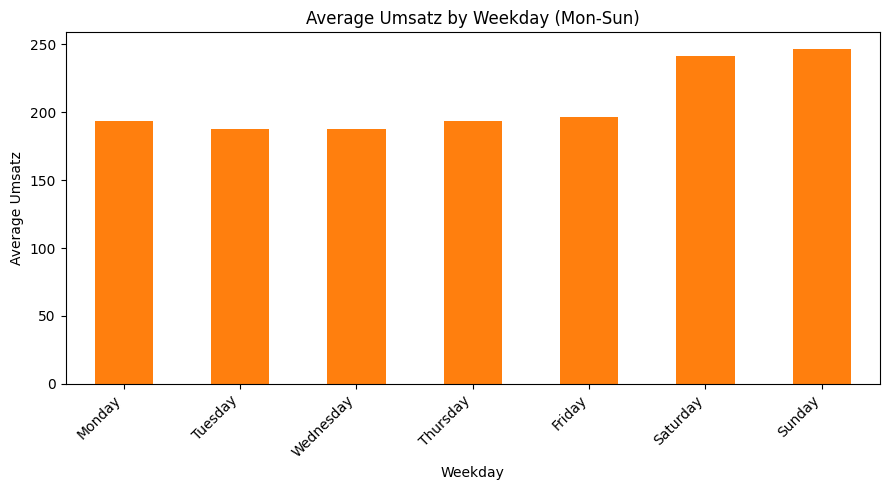

In [11]:
# produce only the bar charts (weekly average, weekly mean with 95% CI, and weekday averages Mon-Sun)

# 1) Average weekly Umsatz (bar)
fig1, ax1 = plt.subplots(figsize=(15, 5))
weekly_avg.plot(kind="bar", ax=ax1, color="tab:blue")
ax1.set_title("Average weekly Umsatz")
ax1.set_xlabel("Week (ending)")
ax1.set_ylabel("Average Umsatz")
step1 = max(1, len(weekly_avg) // 20)
ax1.set_xticks(range(0, len(weekly_avg), step1))
ax1.set_xticklabels([d.strftime("%Y-%m-%d") for d in weekly_avg.index[::step1]], rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2) Average weekly Umsatz with 95% CI (vertical bars with error bars)
fig2, ax2 = plt.subplots(figsize=(15, 5))
x2 = np.arange(len(weekly_stats))
y2 = weekly_stats["mean"].values
yerr2 = z * sem.values
ax2.bar(x2, y2, yerr=yerr2, capsize=3, color="tab:blue", alpha=0.8)
ax2.set_title("Average weekly Umsatz with 95% CI")
ax2.set_xlabel("Week (ending)")
ax2.set_ylabel("Average Umsatz")
step2 = max(1, len(weekly_stats) // 20)
ax2.set_xticks(range(0, len(weekly_stats), step2))
ax2.set_xticklabels([d.strftime("%Y-%m-%d") for d in weekly_stats.index[::step2]], rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3) Average Umsatz by weekday (Monday -> Sunday) as a bar chart
weekday_ordered = weekday_avg.reindex(ordered_weekdays)
fig3, ax3 = plt.subplots(figsize=(9, 5))
weekday_ordered.plot(kind="bar", ax=ax3, color="tab:orange")
ax3.set_title("Average Umsatz by Weekday (Mon-Sun)")
ax3.set_xlabel("Weekday")
ax3.set_ylabel("Average Umsatz")
ax3.set_xticklabels(ordered_weekdays, rotation=45, ha="right")
plt.tight_layout()
plt.show()